## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = 'data/planets/'

In [4]:
ls {"data\planets"}

 Volume in drive C has no label.
 Volume Serial Number is C6AF-373F

 Directory of C:\Varun\Project\fastai\courses\dl1\data\planets

09/04/2018  07:37 PM    <DIR>          .
09/04/2018  07:37 PM    <DIR>          ..
09/10/2018  03:49 AM    <DIR>          models
09/03/2018  03:53 AM         2,914,964 sample_submission_v2.csv
09/10/2018  04:31 AM    <DIR>          test
09/03/2018  03:52 AM           613,971 test_v2_file_mapping.csv
09/10/2018  04:26 AM    <DIR>          test-jpg-additional
09/09/2018  10:23 PM    <DIR>          tmp
09/04/2018  07:01 PM    <DIR>          train
09/03/2018  03:52 AM         1,432,177 train_v2.csv
               3 File(s)      4,961,112 bytes
               7 Dir(s)  78,567,493,632 bytes free


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *

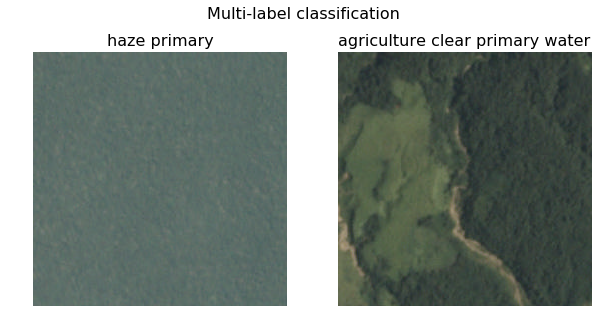

In [6]:
list_paths = [f"{PATH}train/train_0.jpg", f"{PATH}train/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more classes. In the previous example, the first images belongs to two classes: *haze* and *primary*. The second image belongs to four classes: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [69]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [70]:
# Get 20% of data into validation set, so that training can be evaluated against this data.
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
n

In [ ]:
len(val_idxs)


We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.
By default ImageClassifier will consider 20% of traning data in validation index.

In [71]:
#, val_idxs=val_idxs
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', test_name='test')

In [72]:
sz=64

In [73]:
data = get_data(sz)

In [ ]:
## Zooming the image by 1.3 times.
#data = data.resize(int(sz*1.3), 'tmp')

In [74]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.213345   0.251258   0.843453  



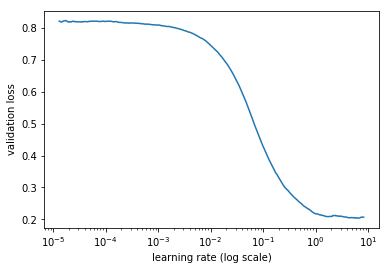

In [75]:
lrf=learn.lr_find()
learn.sched.plot()

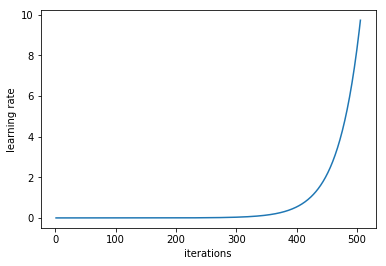

In [76]:
learn.sched.plot_lr()

In [77]:
lr = 0.2

In [78]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.146646   0.131346   0.883793  
    1      0.138152   0.124744   0.89105                                                                               
    2      0.136599   0.122898   0.89278                                                                               
    3      0.138753   0.122431   0.894437                                                                              
    4      0.133459   0.119838   0.895793                                                                              
    5      0.133316   0.119045   0.896769                                                                              
    6      0.129119   0.118619   0.897536                                                                              



[array([0.11862]), 0.8975356874611438]

In [79]:
## Create differential learning rate.
lrs = np.array([lr/9,lr/3,lr])

In [80]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.113378   0.105386   0.91025   
    1      0.11294    0.09911    0.917282                                                                              
    2      0.105257   0.09718    0.917606                                                                              
    3      0.11084    0.098156   0.917322                                                                              
    4      0.102238   0.095019   0.921752                                                                              
    5      0.098827   0.092872   0.92203                                                                               
    6      0.095381   0.092704   0.922167                                                                              



[array([0.0927]), 0.9221667286473928]

In [81]:
learn.save(f'{sz}')

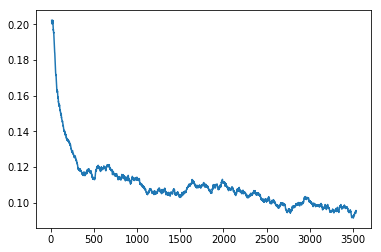

In [82]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
# Since we have freeze the layers,  using learn.fit we are only training last layers (i.e. fully connected conv. n/w).
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [83]:
sz=256

In [84]:
#learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.set_data(get_data(sz))
learn.freeze()
# Since we have freeze the layers,  using learn.fit we are only training last layers (i.e. fully connected conv. n/w).
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.115341   0.104508   0.909548  
    1      0.108321   0.100291   0.913682                                                                              
    2      0.105768   0.098367   0.914907                                                                              
    3      0.104249   0.098289   0.914151                                                                              
    4      0.102264   0.096776   0.916176                                                                              



[array([0.09678]), 0.9161762920929774]

In [ ]:
## This was throwing Cuda out of memory exception.
#learn.unfreeze()

In [85]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                                                                                    
    0      0.102305   0.096296   0.916874  
    1      0.102732   0.095205   0.918029                                                                              
    2      0.100278   0.095002   0.918089                                                                              
    3      0.103974   0.095267   0.916762                                                                              
    4      0.104801   0.09485    0.917285                                                                              
    5      0.099603   0.093707   0.919816                                                                              
    6      0.099213   0.093759   0.919761                                                                              



[array([0.09376]), 0.9197612536939547]

In [86]:
learn.save(f'{sz}')


In [87]:
learn.load(f'{sz}')

In [88]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [63]:
f2(preds,y)

0.9228458281555423

In [89]:
multi_predsTest, _ = learn.TTA(is_test=True) # use test dataset rather than validation dataset
predsTest = np.mean(multi_predsTest,0)

In [90]:
predsTest = np.mean(multi_predsTest,0)

In [91]:
predsTest.shape

(61191, 17)

In [92]:
lbls = predsTest > 0.2
lbls.shape

(61191, 17)

In [93]:
lbls

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### End

['partly_cloudy', 'primary']


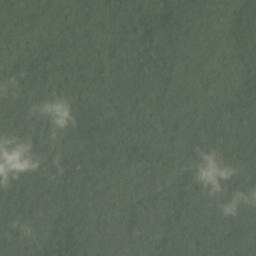

In [94]:
def get_labels(a): 
    return [data.classes[o] for o in a.nonzero()[0]]

#lbls = predsTest > 0.2
idx=9
print(get_labels(lbls[idx]))
PIL.Image.open(PATH+data.test_dl.dataset.fnames[idx]).convert('RGB')

In [95]:
res = [get_labels(o) for o in lbls]
data.test_dl.dataset.fnames[:5]

['test\\file_0.jpg',
 'test\\file_1.jpg',
 'test\\file_10.jpg',
 'test\\file_100.jpg',
 'test\\file_1000.jpg']

In [96]:
outp = pd.DataFrame({'image_name': [f[5:-4] for f in data.test_dl.dataset.fnames],
        'tags': [' '.join(l) for l in res]})
outp.head()

,image_name,tags
0,file_0,clear primary
1,file_1,agriculture clear cultivation partly_cloudy pr...
2,file_10,agriculture haze primary road water
3,file_100,agriculture clear primary road water
4,file_1000,clear primary


In [101]:
outp.to_csv(f'{PATH}/tmp/subm.gz', compression='gzip', index=None)